In [1]:
ID_COL = 'Id'

In [2]:
import pandas as pd
from collections import Counter
import networkx as nx
import pygraphviz as pgv

In [3]:
edge_counter = Counter()
dates = pd.read_csv('./Bosch/train_date.csv', chunksize=10000, index_col=ID_COL)
for date in dates:
    edges = []
    date.rename({col: '_'.join(col.split('_')[:2]) for col in date.columns}, axis=1, inplace=True)
    not_null_msk  = date.T.notnull()
    for item in date.index.tolist():
        item_df = not_null_msk[item]
        vertices = list(dict.fromkeys(item_df[item_df].index.tolist()))
        edges.extend([(vertices[i-1], vertices[i]) for i in range(1, len(vertices))])
    edge_counter.update(Counter(edges))

In [4]:
G = pgv.AGraph(strict=False, directed=True)

In [7]:
ebunch = [(k[0], k[1], v) for k,v in edge_counter.items()]
ebunch_max, ebunch_min = ebunch[0][2], ebunch[-1][2]
reg_ebunch = [(x[0], x[1]) for x in ebunch]
out_nodes = set([k[0] for k,v in edge_counter.items()])
in_nodes = set([k[1] for k,v in edge_counter.items()])
sink_nodes = in_nodes - out_nodes
origin_nodes = out_nodes - in_nodes
norm_ebunch = []
for i, e in enumerate(ebunch):
    norm_ebunch.append((e[0], e[1], (e[2]-ebunch_min)/(ebunch_max-ebunch_min)*5))

In [8]:
sink_nodes, origin_nodes

({'L3_S38', 'L3_S51'}, {'L0_S0'})

In [9]:
lines = ['L0', 'L1', 'L2', 'L3']
colors = ['black', 'red', 'green', 'blue']
node_line = {}
for color, line in zip(colors, lines):
    node_line[line] = [k[0] for k,v in edge_counter.items() if line in k[0]]
    G.add_nodes_from(node_line[line], color=color)

In [10]:
G.add_edges_from(reg_ebunch)

In [21]:
G.layout(prog="dot")
G.draw("file.png")

## 

In [31]:
# Example:
# Many duplicates, because each station has several features. 
# Are all items being measured the same way on each station? TODO
(', ').join(date.loc[2359958][date.loc[2359958].notna()].index.drop_duplicates().tolist())

'L1_S24, L2_S26, L3_S29, L3_S30, L3_S33, L3_S34, L3_S35, L3_S37'

In [33]:
paths = Counter()
dates = pd.read_csv('./Bosch/train_date.csv', chunksize=10000, index_col=ID_COL)
for date in dates:
    edges = []
    date.rename({col: '_'.join(col.split('_')[:2]) for col in date.columns}, axis=1, inplace=True)
    path_batch = []
    for item in date.index.tolist():
        path = (', ').join(date.loc[item][date.loc[item].notna()].index.drop_duplicates().tolist())
        path_batch.append(path)
    paths.update(Counter(path_batch))

In [69]:
nodes, edges = set(), set()
for path in paths.most_common(7):
    path = path[:-1][0].replace(',', '').split()
    for node in path:
        nodes.add(node)
    for i in range(1, len(path)):
        edges.add((path[i-1], path[i]))

In [70]:
nodes

{'L1_S24',
 'L1_S25',
 'L2_S26',
 'L2_S27',
 'L3_S29',
 'L3_S30',
 'L3_S33',
 'L3_S34',
 'L3_S35',
 'L3_S36',
 'L3_S37'}

In [71]:
edges

{('L1_S24', 'L2_S26'),
 ('L1_S24', 'L2_S27'),
 ('L1_S25', 'L2_S26'),
 ('L1_S25', 'L2_S27'),
 ('L2_S26', 'L3_S29'),
 ('L2_S27', 'L3_S29'),
 ('L3_S29', 'L3_S30'),
 ('L3_S30', 'L3_S33'),
 ('L3_S33', 'L3_S34'),
 ('L3_S34', 'L3_S35'),
 ('L3_S34', 'L3_S36'),
 ('L3_S35', 'L3_S37'),
 ('L3_S36', 'L3_S37')}

In [72]:
G = pgv.AGraph(strict=False, directed=True)

In [74]:
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [76]:
G.layout(prog="dot")
G.draw("most_common_paths.png")

In [103]:
counts = sorted([x for x in paths.values() if x>1000], reverse=True)

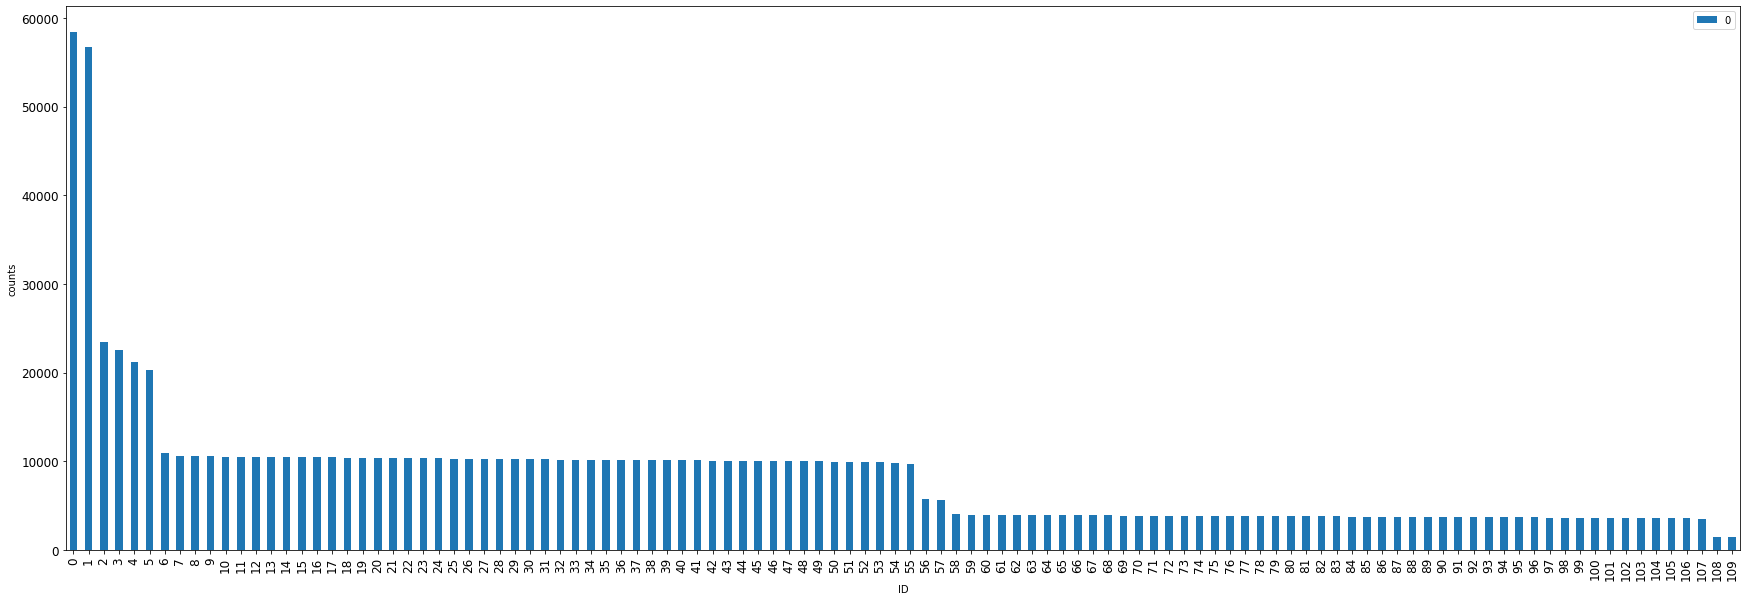

In [109]:
pd.DataFrame(counts).plot.bar(figsize=(30, 10),
                              xlabel='ID',
                              ylabel='counts',
                              fontsize='large');

In [125]:
lines = ['L0', 'L1', 'L2', 'L3']
colors = ['black', 'red', 'green', 'blue']
line_color = {line_id: color for line_id, color  in zip(lines, colors)}

In [126]:
most_common_paths = {}
prev = paths.most_common()[0][-1]
for path in paths.most_common(len(counts)):
    count = path[-1]
    if count < 0.3*prev:
        break
    prev = path[-1]
    most_common_paths[path[:-1]] = count

In [132]:
G = pgv.AGraph(strict=False, directed=True)


In [133]:
nodes, edges = set(), set()
for path in paths.most_common(len(counts)):
    path = path[:-1][0].replace(',', '').split()
    for node in path:
        line = node.split('_')[0]
        nodes.add(node)
        G.add_node(node, color=line_color[line])
    for i in range(1, len(path)):
        line = path[i-1].split('_')[0]
        len_edges = len(edges)
        edges.add((path[i-1], path[i]))
        if len_edges<len(edges):
            G.add_edge((path[i-1], path[i]), color=line_color[line])

In [134]:
#G.add_nodes_from(nodes)
#G.add_edges_from(edges)
G.layout(prog="dot")
G.draw("most_common_paths_extended.png")